## Load packages

In [58]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import helper
style.use('fivethirtyeight')

In [7]:
colors = ["#FF0B04", "#F1BE48",
           "#B9975B", "#8B5B29",
           "#524727",
         ]
sns.set_palette(sns.color_palette(colors))

## Load Data

In [8]:
housing = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0,low_memory = False)


train, test = helper.data_processing_wrapper(housing,
                                               num_to_cat_list = ['MSSubClass'])



In [9]:
cat_feats = train.select_dtypes(['object','bool']).columns.to_list()



In [10]:
num_cols = train.select_dtypes(['float64','int64']).columns.to_list()
num_cols.remove('SalePrice')



## defining functions

In [11]:
def lasso_model_score(alpha, train_, test_, target, 
                             categorical_features,
                             drop_cols = ['SalePrice', 'TotalBsmtSF']):
    scaler = StandardScaler(with_mean=False)
    lasso = Lasso()
    
    
    X = train_.drop(drop_cols,axis=1)
    transformer = ColumnTransformer([("Cat", 
                                      OneHotEncoder(handle_unknown = 'ignore'), 
                                      categorical_features)], remainder='passthrough')
    X = transformer.fit_transform(X)
    X = scaler.fit_transform(X)
    y = np.log(train_[target])
    lasso = Lasso(alpha=alpha)
    selector = SelectFromModel(estimator=lasso)
    X = selector.fit_transform(X, y)
    
    lasso.fit(X,y)
    train_score = lasso.score(X,y)

    X_tst = test_.drop(drop_cols,axis=1)
    X_tst = transformer.transform(X_tst)
    X_tst = scaler.transform(X_tst)
    y_tst = np.log(test_[target])
    X_tst = selector.transform(X_tst)
    test_score = lasso.score(X_tst,y_tst)
    
    
    feat_names = transformer.get_feature_names()
    mask = selector.get_support()
    lasso_feats = [a for a, b in zip(feat_names, mask) if b]
    
    return train_score, test_score,lasso_feats

In [12]:
def plot_lasso_grid_search(
    alpha_start_, alpha_stop_, alpha_num_,
    train_, 
    test_,
    target_, 
    cat_feats_,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],
    n_folds = 3
               ):
    # lasso regression model set up.
    scaler = StandardScaler(with_mean=False)
    lasso = Lasso()

    X = train_.drop(drop_cols,axis=1)
    transformer = ColumnTransformer([("Cat", 
                                      OneHotEncoder(handle_unknown = 'ignore'), 
                                      cat_feats_)], remainder='passthrough')
    X = transformer.fit_transform(X)
    X = scaler.fit_transform(X)
    y = np.log(train_[target_])

    # Grid Search set up.

    alphas = np.linspace(alpha_start_, alpha_stop_, alpha_num_)
    tuned_parameters = [{'alpha': alphas}]
    clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
    clf.fit(X, y)
    
    # graphing data set up
    grid_search_df = pd.DataFrame({
        'split0_test_score':clf.cv_results_['split0_test_score'],
        'split1_test_score':clf.cv_results_['split1_test_score'],
        'split2_test_score':clf.cv_results_['split2_test_score'],
        'mean_test_score':clf.cv_results_['mean_test_score'],
        'param_alpha':clf.cv_results_['param_alpha']
    })

    graph_df = pd.melt(
        grid_search_df,
        id_vars=['param_alpha'], 
        value_vars=['split0_test_score','split1_test_score','split2_test_score']
    )
    graph_df.columns = ['alphas','split_test','model_score']
    
    # graph
    sns.lineplot(data = graph_df,
                x = 'alphas', y = 'model_score',
    #             ax=axs[0]
                 color=colors[0]
                )
    plt.show()

In [13]:
def lasso_train_test_graph(alpha_start, alpha_stop, alpha_num,
               train, 
               test,
               target, 
               cat_feats,
               drop_cols = ['SalePrice', 'TotalBsmtSF']
               ):
    lasso_scores_train = []

    lasso_scores_test  = []
    lasso_feat_len = []

    alphas = np.linspace(alpha_start, alpha_stop, alpha_num)

    for alpha in alphas:
        try:
            train_score, test_score,lasso_feats = lasso_model_score(
                train, 
               test,
               alpha, 
               target, 
               cat_feats,
               drop_cols
            )
            lasso_scores_train.append(train_score)
            lasso_scores_test.append(test_score)
            lasso_feat_len.append(len(lasso_feats))
        except ValueError:
            print(f'Alpha of {alpha} fails')
            lasso_scores_train.append(0)
            lasso_scores_test.append(0)
            lasso_feat_len.append(0)

    lasso_scores_train = np.array(lasso_scores_train) 
    lasso_scores_test  = np.array(lasso_scores_test)
    lasso_feat_len = np.array(lasso_feat_len)
    #graph
    # construct df.
    lasso_alpha_scores = pd.DataFrame({"alphas":alphas,
                'train':lasso_scores_train,
                'test':lasso_scores_test,
                'feature_len':lasso_feat_len,                                       
                                      })
    # change df to graphable structure.
    graph_df = pd.melt(
        lasso_alpha_scores,
        id_vars=['alphas'], 
        value_vars=['train','test']
    )
    graph_df.columns = ['alphas','data_type','model_score']
    
    fig, axs = plt.subplots(2,1,figsize=(10,12))
    sns.lineplot(data = graph_df,
                x = 'alphas', y = 'model_score',hue = 'data_type',
                ax=axs[0]
                )
    # define variable for test train model that is the closest.
    lasso_alpha_scores['train_test_dist'] = abs(lasso_alpha_scores['train'] -
                                                lasso_alpha_scores['test'])
    shortest_dist = lasso_alpha_scores.sort_values('train_test_dist'
                                               ).reset_index(drop = True).loc[0,:]
    best_lasso_alpha = shortest_dist['alphas']
    best_lasso_train = shortest_dist['train']
    best_lasso_test = shortest_dist['test']
    best_lasso_dist = shortest_dist['train_test_dist']

    # construct clostest alpha line
    axs[0].plot([best_lasso_alpha,best_lasso_alpha], 
             [best_lasso_train,best_lasso_test],color=colors[2])
    axs[0].plot(best_lasso_alpha, best_lasso_train,
             marker='o', markersize=8,
             color=colors[2])
    axs[0].plot(best_lasso_alpha, best_lasso_test,
             marker='o', markersize=8,
             color=colors[2])
    # label closest alpha point
    axs[0].text(best_lasso_alpha +.0005, ((best_lasso_test+best_lasso_train)/2), 
             "Alpha = {:.5f}\nDistance = {:.5f}".format(best_lasso_alpha,best_lasso_dist))
    
    # define variable for the test model that has the best score
    
    test_max = lasso_alpha_scores.sort_values('test',ascending=False
                                             ).reset_index(drop = True).loc[0,:]
    best_lasso_alpha = test_max['alphas']
    best_lasso_test = test_max['test']

    axs[0].plot(best_lasso_alpha, best_lasso_test,
             marker='o', markersize=8,
             color=colors[3])
    axs[0].text(best_lasso_alpha +.0005, best_lasso_test, 
         "Alpha = {:.5f}\nScore = {:.3f}".format(best_lasso_alpha,best_lasso_test))
    
    
    

    axs[0].set_title(r'Lasso Train-Test $R^2$ Comparison')
    axs[0].set_xlabel(r'hyperparameter $\alpha$')
    axs[0].set_ylabel(r'$R^2$')
    
    axs[1].set_xlabel(r'hyperparameter $\alpha$')
    axs[1].set_ylabel(r'Number of Features')




    
    sns.lineplot(data = lasso_alpha_scores,
            x = 'alphas', y = 'feature_len',
                 color = colors[2],
            ax=axs[1]
            )
    plt.show()

/Users/julie/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10364413607338374, tolerance: 0.01818667104827771
  model = cd_fast.sparse_enet_coordinate_descent(


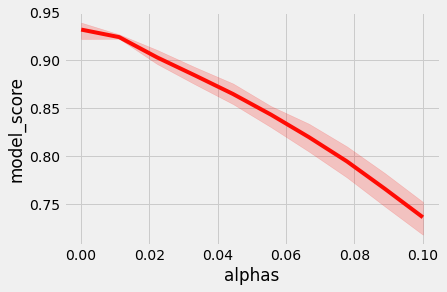

In [14]:
plot_lasso_grid_search(
    0.0001, .1, 10,
    train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],
    n_folds = 3,
               )

/Users/julie/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10364413607338374, tolerance: 0.01818667104827771
  model = cd_fast.sparse_enet_coordinate_descent(


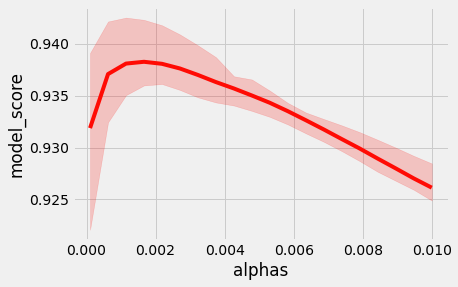

In [15]:
plot_lasso_grid_search(
    0.0001, .01, 20,
    train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],
    n_folds = 3,
               )

/Users/julie/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10364413607338374, tolerance: 0.01818667104827771
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/julie/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0668580193031092, tolerance: 0.01818667104827771
  model = cd_fast.sparse_enet_coordinate_descent(


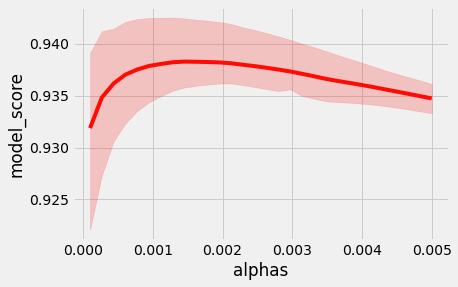

In [16]:
plot_lasso_grid_search(
    0.0001, .005, 30,
    train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],
    n_folds = 3,
               )

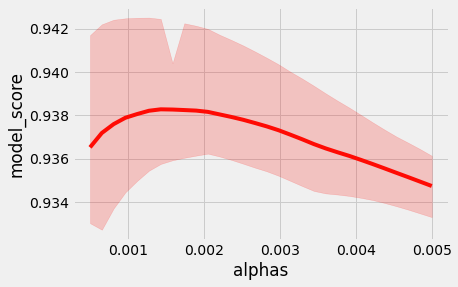

In [17]:
plot_lasso_grid_search(
    0.0005, .005, 30,
    train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],
    n_folds = 3,
               )

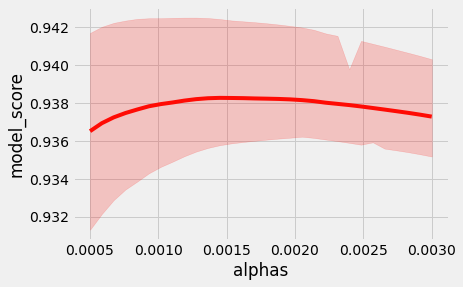

In [18]:
plot_lasso_grid_search(
    0.0005, .003, 30,
    train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],
    n_folds = 3,
               )

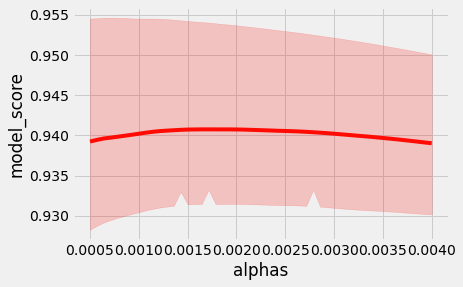

In [19]:
plot_lasso_grid_search(
    0.0005, .004, 50,
    train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],
    n_folds = 5,
               )

Alpha of 0.0005 fails
Alpha of 0.0005714285714285715 fails
Alpha of 0.0006428571428571429 fails
Alpha of 0.0007142857142857143 fails
Alpha of 0.0007857142857142857 fails
Alpha of 0.0008571428571428572 fails
Alpha of 0.0009285714285714286 fails
Alpha of 0.001 fails
Alpha of 0.0010714285714285715 fails
Alpha of 0.001142857142857143 fails
Alpha of 0.0012142857142857144 fails
Alpha of 0.0012857142857142859 fails
Alpha of 0.0013571428571428571 fails
Alpha of 0.0014285714285714288 fails
Alpha of 0.0015 fails
Alpha of 0.0015714285714285715 fails
Alpha of 0.001642857142857143 fails
Alpha of 0.0017142857142857144 fails
Alpha of 0.0017857142857142859 fails
Alpha of 0.0018571428571428573 fails
Alpha of 0.0019285714285714288 fails
Alpha of 0.002 fails
Alpha of 0.0020714285714285713 fails
Alpha of 0.002142857142857143 fails
Alpha of 0.0022142857142857146 fails
Alpha of 0.002285714285714286 fails
Alpha of 0.002357142857142857 fails
Alpha of 0.002428571428571429 fails
Alpha of 0.0025 fails
Alpha of 0

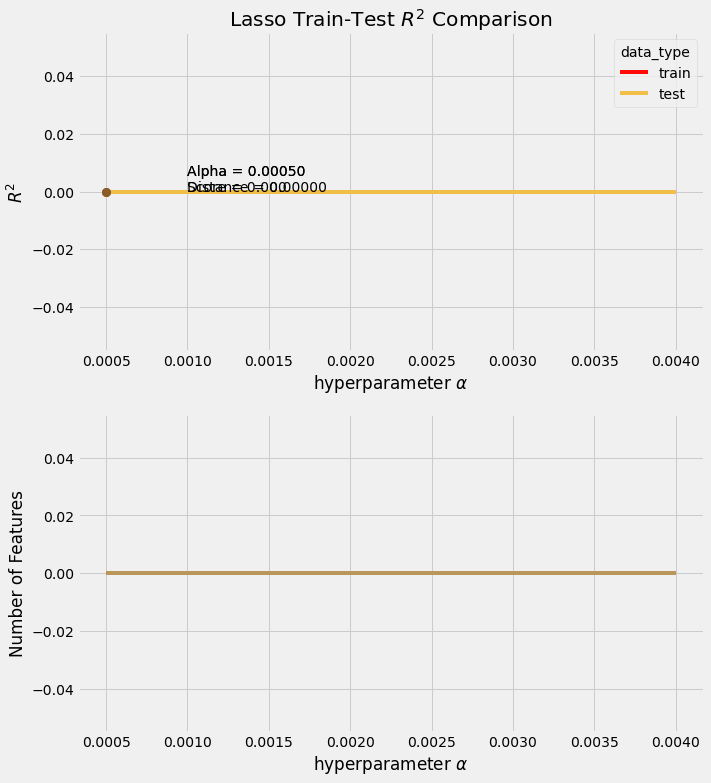

In [20]:
lasso_train_test_graph(0.0005, .004, 50,
    train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],
               )

In [21]:
lasso_model_score(.00275,
                  train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],)

(0.950226185648791,
 0.9109138178428277,
 ['Cat__x0_150',
  'Cat__x0_160',
  'Cat__x0_30',
  'Cat__x0_90',
  'Cat__x1_C (all)',
  'Cat__x1_RH',
  'Cat__x1_RL',
  'Cat__x1_RM',
  'Cat__x2_Grvl',
  'Cat__x4_Bnk',
  'Cat__x6_CulDSac',
  'Cat__x6_FR2',
  'Cat__x8_BrDale',
  'Cat__x8_BrkSide',
  'Cat__x8_ClearCr',
  'Cat__x8_CollgCr',
  'Cat__x8_Crawfor',
  'Cat__x8_Edwards',
  'Cat__x8_Greens',
  'Cat__x8_GrnHill',
  'Cat__x8_MeadowV',
  'Cat__x8_NoRidge',
  'Cat__x8_NridgHt',
  'Cat__x8_OldTown',
  'Cat__x8_SawyerW',
  'Cat__x8_Somerst',
  'Cat__x8_StoneBr',
  'Cat__x8_Veenker',
  'Cat__x9_Feedr',
  'Cat__x9_Norm',
  'Cat__x10_Feedr',
  'Cat__x11_1Fam',
  'Cat__x11_Twnhs',
  'Cat__x13_Flat',
  'Cat__x15_BrkComm',
  'Cat__x15_BrkFace',
  'Cat__x15_HdBoard',
  'Cat__x15_PreCast',
  'Cat__x16_AsbShng',
  'Cat__x16_CBlock',
  'Cat__x16_Plywood',
  'Cat__x16_VinylSd',
  'Cat__x16_Wd Shng',
  'Cat__x18_BrkTil',
  'Cat__x18_PConc',
  'Cat__x18_Wood',
  'Cat__x19_ALQ',
  'Cat__x19_GLQ',
  'Cat__x

In [22]:
lasso_model_score(.004,
                  train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],)

(0.9469059001914502,
 0.9088902567995484,
 ['Cat__x0_150',
  'Cat__x0_160',
  'Cat__x0_30',
  'Cat__x1_C (all)',
  'Cat__x1_RH',
  'Cat__x1_RM',
  'Cat__x4_Bnk',
  'Cat__x6_CulDSac',
  'Cat__x8_BrkSide',
  'Cat__x8_ClearCr',
  'Cat__x8_Crawfor',
  'Cat__x8_Edwards',
  'Cat__x8_GrnHill',
  'Cat__x8_MeadowV',
  'Cat__x8_NoRidge',
  'Cat__x8_NridgHt',
  'Cat__x8_OldTown',
  'Cat__x8_SawyerW',
  'Cat__x8_Somerst',
  'Cat__x8_StoneBr',
  'Cat__x9_Feedr',
  'Cat__x9_Norm',
  'Cat__x11_1Fam',
  'Cat__x11_Twnhs',
  'Cat__x13_Flat',
  'Cat__x15_BrkComm',
  'Cat__x15_BrkFace',
  'Cat__x15_PreCast',
  'Cat__x16_AsbShng',
  'Cat__x16_CBlock',
  'Cat__x16_Wd Shng',
  'Cat__x18_BrkTil',
  'Cat__x18_PConc',
  'Cat__x19_ALQ',
  'Cat__x19_GLQ',
  'Cat__x19_LwQ',
  'Cat__x20_GLQ',
  'Cat__x22_N',
  'Cat__x24_Maj1',
  'Cat__x24_Maj2',
  'Cat__x24_Typ',
  'Cat__x25_Attchd',
  'Cat__x25_Basment',
  'Cat__x28_Con',
  'Cat__x29_Normal',
  'GrLivArea',
  'LotFrontage',
  'LotArea',
  'OverallQual',
  'Overall

In [23]:
lasso_model_score(.0005,
                  train, 
    test,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],)

(0.9564244431920096,
 0.9091499843025826,
 ['Cat__x0_150',
  'Cat__x0_160',
  'Cat__x0_20',
  'Cat__x0_30',
  'Cat__x0_40',
  'Cat__x0_45',
  'Cat__x0_50',
  'Cat__x0_60',
  'Cat__x0_70',
  'Cat__x0_75',
  'Cat__x0_80',
  'Cat__x0_85',
  'Cat__x0_90',
  'Cat__x1_A (agr)',
  'Cat__x1_C (all)',
  'Cat__x1_I (all)',
  'Cat__x1_RH',
  'Cat__x1_RL',
  'Cat__x1_RM',
  'Cat__x2_Grvl',
  'Cat__x3_IR2',
  'Cat__x3_IR3',
  'Cat__x4_Bnk',
  'Cat__x4_HLS',
  'Cat__x4_Low',
  'Cat__x6_Corner',
  'Cat__x6_CulDSac',
  'Cat__x6_FR2',
  'Cat__x6_FR3',
  'Cat__x7_Mod',
  'Cat__x7_Sev',
  'Cat__x8_BrDale',
  'Cat__x8_BrkSide',
  'Cat__x8_ClearCr',
  'Cat__x8_CollgCr',
  'Cat__x8_Crawfor',
  'Cat__x8_Edwards',
  'Cat__x8_Greens',
  'Cat__x8_GrnHill',
  'Cat__x8_IDOTRR',
  'Cat__x8_Landmrk',
  'Cat__x8_MeadowV',
  'Cat__x8_NAmes',
  'Cat__x8_NWAmes',
  'Cat__x8_NoRidge',
  'Cat__x8_NridgHt',
  'Cat__x8_OldTown',
  'Cat__x8_SWISU',
  'Cat__x8_Sawyer',
  'Cat__x8_SawyerW',
  'Cat__x8_Somerst',
  'Cat__x8_Sto

## Feature Engineering
### CompSalePrice

In [36]:
nbrhd_med = train.groupby('Neighborhood').agg({'SalePrice':'median'})
nbrhd_med.columns = ['CompSalePrice']

In [87]:
train_ft = train.merge(nbrhd_med, how='left', left_on='Neighborhood', right_on='Neighborhood')

In [88]:
# Apply it to test
test_ft = test.merge(nbrhd_med, how='left', left_on='Neighborhood', right_on='Neighborhood')

In [48]:
# 0.9564132348220067,0.9093651154948325 with compSalePrice, no dropping

lasso_model_score(.0005,
                  train_ft, 
    test_ft,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],)

(0.7749341057144854,
 0.7486551837837029,
 ['GrLivArea',
  'OverallQual',
  'BsmtFinSF1',
  '1stFlrSF',
  'GarageCars',
  'GarageArea',
  'CompSalePrice'])

###  Adjusting GarageCars

In [54]:
train2 = train.copy()

<AxesSubplot:xlabel='GarageCars', ylabel='logSP'>

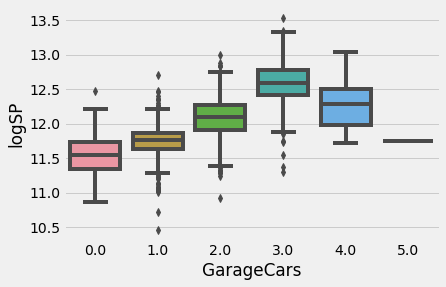

In [55]:
train2['logSP'] = np.log(train2.SalePrice)
sns.boxplot(data=train2, y='logSP', x='GarageCars')

In [113]:
medCars = train2.groupby('GarageCars').agg({'logSP':'median'}).reset_index()
medCars.columns = ['GarageCars', 'GarageCarComp']

In [114]:
test_ft.GarageCars

0      1.0
1      1.0
2      2.0
3      2.0
4      2.0
      ... 
619    2.0
620    2.0
621    1.0
622    3.0
623    3.0
Name: GarageCars, Length: 624, dtype: float64

In [71]:
tmp.iloc[0:4,0]

0    0.0
1    1.0
2    2.0
3    3.0
Name: GarageCars, dtype: float64

In [74]:
lr = LinearRegression()
x = tmp.iloc[0:4,0]
y = tmp.iloc[0:4,1]

In [76]:
# lr.fit(x, y)

In [ ]:
# train_ft['carsLog'] = np.log(train_ft['GarageCars'])
train_ft['carsSqrRt'] = train_ft['GarageCars']**0.5
train_ft['carsSqr'] = train_ft['GarageCars']**2
train_ft['carsCub'] = train_ft['GarageCars']**3

# test_ft['carsLog'] = np.log(test_ft['GarageCars'])
test_ft['carsSqrRt'] = test_ft['GarageCars']**0.5
test_ft['carsSqr'] = test_ft['GarageCars']**2
test_ft['carsCub'] = test_ft['GarageCars']**3

In [99]:
# train_ft['carsLog'] = np.log(train_ft['GarageCars'])
train_ft['carsSqrRt_norm'] = (train_ft['GarageCars']/3)**0.5
train_ft['carsSqr_norm'] = (train_ft['GarageCars']/3)**2
train_ft['carsCub_norm'] = (train_ft['GarageCars']/3)**3

# test_ft['carsLog'] = np.log(test_ft['GarageCars'])
test_ft['carsSqrRt_norm'] = (test_ft['GarageCars']/3)**0.5
test_ft['carsSqr_norm'] = (test_ft['GarageCars']/3)**2
test_ft['carsCub_norm'] = (test_ft['GarageCars']/3)**3

In [108]:
# test_ft = test_ft.merge(medCars, how='left', left_on='GarageCars', right_on='GarageCars')
train_ft = train_ft.merge(medCars, how='left', left_on='GarageCars', right_on='GarageCars')

In [118]:
lasso_model_score(.09,
                  train_ft, 
    test_ft,
    'SalePrice', 
    cat_feats,
    drop_cols = ['SalePrice', 'TotalBsmtSF'],)

(0.7748626294304375,
 0.7481927750940054,
 ['GrLivArea',
  'OverallQual',
  'BsmtFinSF1',
  '1stFlrSF',
  'GarageArea',
  'CompSalePrice',
  'logSP'])